# Model manager of the Load Curve modelling 

This notebook is intented to be a user-friendly approach of the **load curve model**. Just run the steps you need. 
## 1 - Make dataset 
This steps is the whole preprocessing pipeline of the data. From the download of weather data, the preparation of annual demands, hourly load data to the split into train set and test set. Inputs to provide during the run : **split_week_end** (e.g whether you want to split week end in saturday and sunday) , **not_use_wem_inputs** (whether you want to use WEM inputs hourly load by subsector for the training. If False, the model uses the annual demand of subsector only. There is just one phase of training.), **pop_weighted** (e.g whether you want the WEM inputs hourly_load disaggregation using population averaged or using annual demand)

## 2 - Train model

This is the train model step. The model architecture is the following : **The model estimates the hourly demand of end-use cluster from the total load electricity demand and explanatory variables such as temperature, solar irradiance and time features**

The model is composed of a **MultiLayer perceptron for each end-use-cluster**. These MLP are trained together in order to compute the total load and compare it to the actual load. **The inputs are explanatory variables** (temperature, solar irradiance, features) and **the annual demand for the end-use cluster for each country.** How it works ? The artifical neural network finds correlation between explanatory variables and the total load to fit the actual load. 

<img src='Picture/Picture1.png' width="800" height="800" align = "center" >

## 3 - Predict results

Basically predict results on the test set and assess the performance of the model. After running that cell. You can find here : **Load_curve_modelling/models/Results analysis.pynb** the whole routine to visualize graphs using the outputs of the model and save them + evaluate model performance.

# 1 - Make dataset 

Run the following cell if datasets are not already computed and saved to disk. 

In [1]:
#if kernel died for no reason run this cell: 
import os 
os.environ['KMP_DUPLICATE_LIB_OK']='True' 

In [6]:
%run src/data/make_dataset.py 

2021-08-18 22:08:46,414 - __main__ - INFO - Processing and combining raw data
2021-08-18 22:08:46,415 - __main__ - INFO - Mother folder: iea_load_curve_modelling


Not use wem inputs to train the model ? True or False False
Population weighted ? True or False True


2021-08-18 22:08:51,222 - src.data.process_annual_demand - INFO - Processing historical annual demand data


You have chosen to use the following parameters to make dataset :
 split week end : True 
 WEM inputs : True 
 Population weighted decomposition of WEM region hourly load : True


2021-08-18 22:08:53,087 - src.data.process_annual_demand - INFO - Loaded data from ETP
2021-08-18 22:08:53,908 - src.data.process_annual_demand - INFO - Loaded data from EDC
2021-08-18 22:08:53,913 - src.data.process_annual_demand - WARNING - ⚠️ - Data for SGP is not 100% correct : residential and commercial demand data for singapore only works with non-temperature dependant uses aggregated together
2021-08-18 22:08:53,957 - src.data.process_hourly_weather - INFO - Processing hourly weather data (dropping years up to 2002)
2021-08-18 22:08:54,986 - src.data.process_hourly_weather - INFO - Added weather data for FRA - 2003-01-01 00:00:00+00:00 to 2019-12-31 23:00:00+00:00
2021-08-18 22:08:56,118 - src.data.process_hourly_weather - INFO - Added weather data for FRA_RES - 2003-01-01 00:00:00+00:00 to 2019-12-31 23:00:00+00:00
2021-08-18 22:08:57,212 - src.data.process_hourly_weather - INFO - Added weather data for FRA_PRO - 2003-01-01 00:00:00+00:00 to 2019-12-31 23:00:00+00:00
2021-08-18

FileNotFoundError: [Errno 2] File C:\Users\PEREIRA_LU\Desktop\Load_curve_modelling\data\mapping\country_mapping.csv does not exist: 'C:\\Users\\PEREIRA_LU\\Desktop\\Load_curve_modelling\\data\\mapping\\country_mapping.csv'

### 1.1 Let's have a quick look to the data set

['FRA',
 'DEU',
 'ITA',
 'GBR',
 'DNK',
 'FIN',
 'SWE',
 'NOR',
 'US_FL',
 'US_NY',
 'IND']

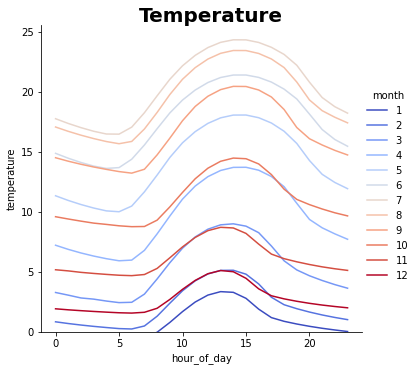

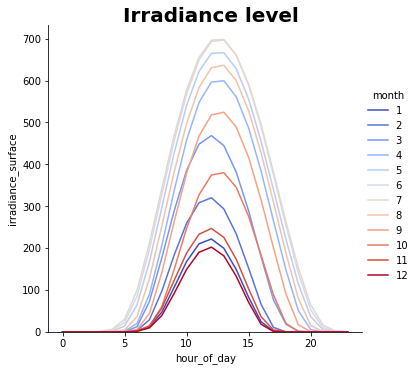

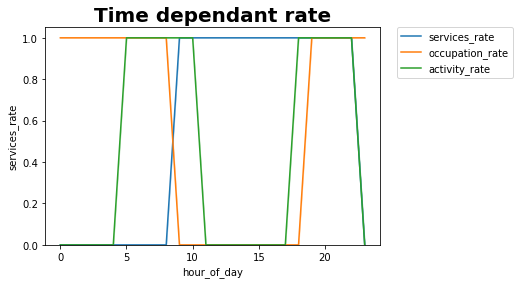

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option("display.max_columns",None)
df = pd.read_csv('data/processed/processed_historical_test_set.csv')


ax1 = sns.relplot(x='hour_of_day', y='temperature',hue = 'month', kind='line', 
            data=df,palette = 'coolwarm',legend = 'full',facet_kws=dict(sharey=False),ci = None)
ax1.fig.subplots_adjust(top=0.93)
ax1.fig.suptitle('Temperature', fontsize = 20, fontweight = 'bold')
ax1.set(ylim = (0))

ax2 = sns.relplot(x='hour_of_day', y='irradiance_surface',hue = 'month', kind='line', 
            data=df,palette = 'coolwarm',legend = 'full',facet_kws=dict(sharey=False),ci = None)
ax2.fig.subplots_adjust(top=0.93)
ax2.fig.suptitle('Irradiance level', fontsize = 20, fontweight = 'bold')
ax2.set(ylim = (0))

plt.figure()
sns.lineplot(x='hour_of_day', y='services_rate', 
            data=df,label = 'services_rate')
sns.lineplot(x='hour_of_day', y='occupation_rate', 
            data=df,label = 'occupation_rate')
sns.lineplot(x='hour_of_day', y='activity_rate', 
            data=df,label = 'activity_rate')
plt.legend(bbox_to_anchor=(1.05, 1),borderaxespad=0)
plt.title('Time dependant rate',fontsize = 20, fontweight = 'bold')
plt.ylim(0)

df.country.unique().tolist()

# 2 - Train model

The trained models are saved here : **Load_curve_modelling/models/version_number** Note that you have a model trained on all countries and one folder per country. It denotes all the country specific models.

### 2.1 Define the parameters of the model

If you make changes, run the cells to update the parameters files.
You can find here for each subsectors the **features associated** (e.g explanatory variables used by the model to find correlation between them and the subsector's load), and sometimes a **penalty** with other **hyper parameters**. 

#### 2.1.1 Irradiance penalty definition

It aims to produce curves not only based on the irradiance penalty but also on the activty of services & residential. This loss aims to **add a penalty when the irradiance surface is higher than a certain threshold and when people are not active/awaken**. Because lighting is unlikely to happen when the irradiance surface is high/people are not active.  It is defined as followed : 
#### $loss = [f_{lighting}(t)(\alpha p_{hour} + p_{lighting})]^{2}$  
##### where :  $p_{hour} = 1 - activity$
##### and : $p_{lighting} = \max(0,irradiance(t) - threshold) $

#### 2.1.1 Temperature penalty definition

This loss aims to **add a penalty when the temperature is higher/lower than a certain temperature threshold because cooling/heating is unlikely to happen when the temperature is low/high**.  It is defined as followed : 
#### $loss = \alpha (f_{heating/cooling}(t)\Delta T) ^2 $  
##### where :  $\Delta T = \max (0,T(t) - threshold)$ *if heating*
##### and : $\Delta T = \max (0,threshold-T(t))$ *if cooling*

In [3]:
import yaml 

#The subsector mapping first : 
subsector_mapping = {
        'clu_01': {
            'subsectors': [
                'RES_CK', 'SER_OT', 'RES_AP',
                'IND_CE', 'IND_IS', 'IND_NS', 'IND_CH', 'IND_AL', 'IND_PA',
                'IND_MI', 'IND_CO', 'IND_TR', 'IND_MA', 'IND_FO', 'IND_WO',
                'IND_TE', 'TRA_RA', 'TRA_RO',
            ],
            'features': ['cos_h', 'sin_h', 'weekday', 'cos_w', 'sin_w','services_rate'],
        },
        'res_LI': {
            'subsectors': ['RES_LI'],
            'features': ['cos_h', 'sin_h', 'weekday', 'irradiance_surface','activity_rate'],
            'irradiance_penalty_res' : {'threshold': 350, 'weight' : 5} #weight corresponds to the alpha term (see above)
            },
        'ser_LI': {
            'subsectors': ['SER_LI'],
            'features': ['cos_h', 'sin_h', 'weekday', 'irradiance_surface','services_rate'],
            'irradiance_penalty_ser' : {'threshold': 350, 'weight' :1 } #weight corresponds to the alpha term (see above)
            },
        'res_SH': {
            'subsectors': ['RES_SH', 'RES_WH'],
            'features': ['cos_h', 'sin_h', 'weekday', 'temperature','occupation_rate'],
            'heating_penalty': {'threshold': 18.,
                                'weight': 1} #weight corresponds to the alpha term (see above)
        },
        'ser_SH': {
            'subsectors': ['SER_SH', 'SER_WH'],
            'features': ['cos_h', 'sin_h', 'weekday', 'temperature','services_rate'],
            'heating_penalty': {'threshold': 18.,
                                'weight': 1} #weight corresponds to the alpha term (see above)
        },
        'res_SC': {
            'subsectors': ['RES_SC'],
            'features': ['cos_h', 'sin_h', 'weekday', 'temperature', 'cos_w', 'sin_w','occupation_rate'],
            'cooling_penalty': {'threshold': 20.,
                                'weight': 0.1} #weight corresponds to the alpha term (see above)
        },
        'ser_SC': {
            'subsectors': ['SER_SC'],
            'features': ['cos_h', 'sin_h', 'weekday', 'temperature', 'cos_w', 'sin_w','services_rate'],
            'cooling_penalty': {'threshold': 20.,
                                'weight': 0.1} #weight corresponds to the alpha term (see above)
        }
    }
#The confidence interval percentage of each cluster for WEM training
ci_ratio = {'CLU_01' : 0.3, 'CLU_LI' : 0.2 , 'CLU_SH' : 0.2 , 'CLU_SC' : 0.2}

#The parameters of the neural network 
hparams = {'n_layers' : 1, #Number of layers in the LSTM (has to be done manually for the MLP)
        'max_epochs' : 400, 
        'epochs_wem' : 0.15, # Percentage to apply on max_epochs to compute the max_epochs_wem
        'batch_size':4,
        'dim_hidden': 40, #Number of neurons in the hidden layer of the MLP
        #'dim_hidden_lstm' : 2, #Number of hidden nodes in the LSTM
        'optimizer_name': 'adam', #Optimizer of the ANN
        'dropout_rate' : 0,
        'lr': 0.001, #learning rate of the ANN
        'subsector_mapping': subsector_mapping,
        'not_use_wem_inputs' : True, #Don't touch this argument   
        'h_ratio' : ci_ratio
    }

#Saving these parameters as configuration files : 
with open('models/logs/hparams_init.yaml','w') as yamlfile : 
    yaml.dump(hparams,yamlfile)
with open('models/logs/subsector_mapping.yaml','w') as yamlfile : 
    yaml.dump(subsector_mapping,yamlfile)
with open('models/logs/ci_ratio.yaml','w') as yamlfile : 
    yaml.dump(ci_ratio,yamlfile)

### 2.2 Run the model

In [4]:
%run src/models/train_model.py

#if kernel died for no reason try : 
#import os 
#os.environ['KMP_DUPLICATE_LIB_OK']='True' 

ETP inputs ? True or False  -- If False, will use WEM inputs True


2021-08-18 22:01:32,093 - __main__ - INFO - The algorithm will train using WEM inputs set on : False
2021-08-18 22:01:36,081 - src.data.load_processed_data - INFO - Ignoring countries []
2021-08-18 22:01:38,231 - src.data.load_processed_data - INFO - Scaled subsector annual demands (ETP) to match the total historical load over the year
2021-08-18 22:01:38,236 - src.data.load_processed_data - INFO - Scaled load data to MW/25884.245768672616
2021-08-18 22:01:38,424 - src.data.load_processed_data - INFO - FRA - created input and output tensors (8 samples)
2021-08-18 22:01:38,568 - src.data.load_processed_data - INFO - DEU - created input and output tensors (9 samples)
2021-08-18 22:01:38,709 - src.data.load_processed_data - INFO - ITA - created input and output tensors (8 samples)
2021-08-18 22:01:38,762 - src.data.load_processed_data - INFO - GBR - created input and output tensors (1 samples)
2021-08-18 22:01:38,813 - src.data.load_processed_data - INFO - DNK - created input and output t

Training: -1it [00:00, ?it/s]

C:\Users\lucas\anaconda3\lib\site-packages\pytorch_lightning\trainer\connectors\logger_connector\result.py:397: LightningDeprecationWarning: One of the returned values {'log'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  warning_cache.deprecation(


epoch 399/400 & loss : 56.354393005371094

2021-08-18 22:02:17,008 - __main__ - INFO - Training the generic model on advanced_economies countries
2021-08-18 22:02:17,014 - pytorch_lightning.utilities.distributed - INFO - GPU available: False, used: False
2021-08-18 22:02:17,016 - pytorch_lightning.utilities.distributed - INFO - TPU available: False, using: 0 TPU cores
2021-08-18 22:02:17,018 - pytorch_lightning.utilities.distributed - INFO - IPU available: False, using: 0 IPUs
2021-08-18 22:02:17,056 - pytorch_lightning.core.lightning - INFO - 
  | Name           | Type         | Params
------------------------------------------------
0 | main_net       | MainNet      | 2.2 K 
1 | mse_total_load | TotalLoadMSE | 0     
2 | interval_loss  | IntervalLoss | 0     
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


epoch 400/400 & loss : 56.0907096862793

C:\Users\lucas\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:322: UserWarning: The number of training samples (13) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: -1it [00:00, ?it/s]

epoch 52/400 & loss : 0.037778362631797794

C:\Users\lucas\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:1047: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
2021-08-18 22:05:07,609 - __main__ - INFO - Training the model on country FRA
2021-08-18 22:05:07,614 - pytorch_lightning.utilities.distributed - INFO - GPU available: False, used: False
2021-08-18 22:05:07,615 - pytorch_lightning.utilities.distributed - INFO - TPU available: False, using: 0 TPU cores
2021-08-18 22:05:07,616 - pytorch_lightning.utilities.distributed - INFO - IPU available: False, using: 0 IPUs


epoch 53/400 & loss : 2.0313267707824707

C:\Users\lucas\anaconda3\lib\site-packages\pytorch_lightning\trainer\trainer.py:531: LightningDeprecationWarning: `trainer.fit(train_dataloader)` is deprecated in v1.4 and will be removed in v1.6. Use `trainer.fit(train_dataloaders)` instead. HINT: added 's'
  rank_zero_deprecation(
2021-08-18 22:05:07,745 - pytorch_lightning.core.lightning - INFO - 
  | Name           | Type         | Params
------------------------------------------------
0 | main_net       | MainNet      | 2.2 K 
1 | mse_total_load | TotalLoadMSE | 0     
2 | interval_loss  | IntervalLoss | 0     
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
C:\Users\lucas\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:322: UserWarning: The number of training samples (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps i

Training: -1it [00:00, ?it/s]

epoch 1/400 & loss : 1.9169757366180428

2021-08-18 22:05:08,483 - __main__ - INFO - Training the model on country DEU
2021-08-18 22:05:08,489 - pytorch_lightning.utilities.distributed - INFO - GPU available: False, used: False
2021-08-18 22:05:08,490 - pytorch_lightning.utilities.distributed - INFO - TPU available: False, using: 0 TPU cores
2021-08-18 22:05:08,491 - pytorch_lightning.utilities.distributed - INFO - IPU available: False, using: 0 IPUs
2021-08-18 22:05:08,606 - pytorch_lightning.core.lightning - INFO - 
  | Name           | Type         | Params
------------------------------------------------
0 | main_net       | MainNet      | 2.2 K 
1 | mse_total_load | TotalLoadMSE | 0     
2 | interval_loss  | IntervalLoss | 0     
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
C:\Users\lucas\anaconda3\lib\site-packages\pytorch_lightning\trainer\data_loading.py:322: UserWarning: The number of 

Training: -1it [00:00, ?it/s]

2021-08-18 22:05:09,027 - __main__ - INFO - Training the model on country ITA


epoch 1/400 & loss : 3.834904432296753

2021-08-18 22:05:09,032 - pytorch_lightning.utilities.distributed - INFO - GPU available: False, used: False
2021-08-18 22:05:09,033 - pytorch_lightning.utilities.distributed - INFO - TPU available: False, using: 0 TPU cores
2021-08-18 22:05:09,034 - pytorch_lightning.utilities.distributed - INFO - IPU available: False, using: 0 IPUs
2021-08-18 22:05:09,150 - pytorch_lightning.core.lightning - INFO - 
  | Name           | Type         | Params
------------------------------------------------
0 | main_net       | MainNet      | 2.2 K 
1 | mse_total_load | TotalLoadMSE | 0     
2 | interval_loss  | IntervalLoss | 0     
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)
2021-08-18 22:05:09,174 - __main__ - INFO - Training the model on country GBR
2021-08-18 22:05:09,180 - pytorch_lightning.utilities.distributed - INFO - GPU available: False, used: False
2021-08-

Training: -1it [00:00, ?it/s]

epoch 8/400 & loss : 0.011211959645152092

2021-08-18 22:05:13,124 - __main__ - INFO - Training the model on country SWE
2021-08-18 22:05:13,130 - pytorch_lightning.utilities.distributed - INFO - GPU available: False, used: False
2021-08-18 22:05:13,132 - pytorch_lightning.utilities.distributed - INFO - TPU available: False, using: 0 TPU cores
2021-08-18 22:05:13,133 - pytorch_lightning.utilities.distributed - INFO - IPU available: False, using: 0 IPUs


epoch 9/400 & loss : 0.008344816975295544

2021-08-18 22:05:13,243 - pytorch_lightning.core.lightning - INFO - 
  | Name           | Type         | Params
------------------------------------------------
0 | main_net       | MainNet      | 2.2 K 
1 | mse_total_load | TotalLoadMSE | 0     
2 | interval_loss  | IntervalLoss | 0     
------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.009     Total estimated model params size (MB)


Training: -1it [00:00, ?it/s]

epoch 18/400 & loss : 0.016776554286479953

2021-08-18 22:05:19,982 - __main__ - INFO - Training the model on country NOR
2021-08-18 22:05:19,988 - pytorch_lightning.utilities.distributed - INFO - GPU available: False, used: False
2021-08-18 22:05:19,989 - pytorch_lightning.utilities.distributed - INFO - TPU available: False, using: 0 TPU cores
2021-08-18 22:05:19,990 - pytorch_lightning.utilities.distributed - INFO - IPU available: False, using: 0 IPUs


epoch 19/400 & loss : 0.023623565211892128

KeyboardInterrupt: 

## 3 - Predict model

The prediction of the models are saved here : **Load_curve_modelling/models/version_number in excel format**. Then visualize and assess model performance using the ***Results analysis*** notebook

In [2]:
#Get the last version number of the directory
import os
list = os.listdir('models/logs')
maximum = 'version_0'
for l in list : 
    if 'version' in l : 
        if int(l.split(sep = '_')[1]) > int(maximum.split(sep = '_')[1]) : 
            maximum = l
       
print('Last version in the directory is',maximum)

%run src/models/predict_model.py

Last version in the directory is version_24


Version number 24
Enter the scenario you want to predict : historical, SDS2050, STEPS2050 SDS2050


2021-08-26 14:41:38,030 - __main__ - INFO - Loaded experiment 24, using subsector mapping : 
clu_01:
  features:
  - cos_h
  - sin_h
  - weekday
  - cos_w
  - sin_w
  - services_rate
  subsectors:
  - RES_CK
  - SER_OT
  - RES_AP
  - IND_CE
  - IND_IS
  - IND_NS
  - IND_CH
  - IND_AL
  - IND_PA
  - IND_MI
  - IND_CO
  - IND_TR
  - IND_MA
  - IND_FO
  - IND_WO
  - IND_TE
  - TRA_RA
  - TRA_RO
res_LI:
  features:
  - cos_h
  - sin_h
  - weekday
  - irradiance_surface
  - activity_rate
  irradiance_penalty_res:
    threshold: 150
    weight: 5
  subsectors:
  - RES_LI
res_SC:
  cooling_penalty:
    threshold: 20.0
    weight: 0.05
  features:
  - cos_h
  - sin_h
  - weekday
  - temperature
  - cos_w
  - sin_w
  - occupation_rate
  subsectors:
  - RES_SC
res_SH:
  features:
  - cos_h
  - sin_h
  - weekday
  - temperature
  - occupation_rate
  heating_penalty:
    threshold: 18.0
    weight: 0.1
  subsectors:
  - RES_SH
  - RES_WH
ser_LI:
  features:
  - cos_h
  - sin_h
  - weekday
  - irra

FileNotFoundError: [Errno 2] File C:\Users\lucas\Documents\Stage\IEA\Load_curve_modelling\data\processed\processed_SDS2050_test_set.csv does not exist: 'C:\\Users\\lucas\\Documents\\Stage\\IEA\\Load_curve_modelling\\data\\processed\\processed_SDS2050_test_set.csv'

## 4 - Connect the data of the load curve model with the World Energy Model

The output is an excel file with the same format as in the WEM excel files here : *G:\EO2021\Model\Sectors\RES\DSR\Model*.

In [5]:
%run src/data/connect_wem.py

2021-07-01 12:00:56,645 - __main__ - INFO - Computing data and shares for typical days, month etc..
2021-07-01 12:01:03,116 - __main__ - INFO - Saving data in the folder :C:\Users\PEREIRA_LU\Desktop\Load_curve_modelling\models\logs\version_24\output_historical.csv
2021-07-01 12:01:03,854 - __main__ - INFO - Done ! 
